In [1]:
from jqdata import *
import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO
from dateutil.parser import parse
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy
import talib as tl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['font.family']='serif'
mpl.rcParams['axes.unicode_minus']=False # 处理负号


def get_profit(data,start_date,end_date,rate_riskfree=0):
    '''
    data:计算好的带有position的数据，决定每月的买入卖出决策
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    df_pct['pct']=prices.pct_change()
    rate_riskfree = 0
    df_pct = pd.concat([df_pct,data],axis=1)[start_date:end_date].dropna()
    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    df_pct[['net_value','net_value_timing']].plot(figsize=(15,6))
    return df_pct



In [3]:
def get_month_list(start_date, end_date):
    sy = int(start_date[:4])
    ey = int(end_date[:4])
    sm = int(start_date[5:7])
    em = int(end_date[5:7])
    l = []
    for y in range(sy, ey + 1):
        if y == sy:
            for i in range(sm, 13):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)

        elif y == ey:
            for i in range(1, em + 1):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)
        else:
            for i in range(1, 13):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)
    return l

#获取label值
def get_profit_monthly(start_date,end_date,cut_list=[-0.00,0.00],label=True,rate_riskfree=0):
    '''
    data:position数据，1列，前期计算出择时position
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    cut_list:分类切点，注意二分类和多分类时后续算法的区别
    label:决定输出的是分类结果还是连续结果
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    prices_M = prices.resample('M',how='last')
    month_list = get_month_list(start_date,end_date)
    prices_M.index = month_list
    df_pct['pct']=prices_M.pct_change().dropna()
    def fun(x):
        if x > cut_list[-1]:
            y = 1
        elif x < cut_list[0]:
            y = -1
        else:
            y = 0
        return y
    if label:
        df_pct = df_pct.applymap(lambda x: fun(x))
    return df_pct

#计算最大回撤
def find_max_drawdown(returns):
    # 定义最大回撤的变量
    result = 0
    # 记录最高的回报率点
    historical_return = 0
    # 遍历所有日期
    for i in range(len(returns)):
        # 最高回报率记录
        historical_return = max(historical_return, returns[i])
        # 最大回撤记录
        drawdown = 1 - (returns[i]) / (historical_return)
        # 记录最大回撤
        result = max(drawdown, result)
    # 返回最大回撤值
    return result

def get_profit_res(data,start_date,end_date,rate_riskfree=0,plot=True):
    '''
    data:position数据，1列，前期计算出择时position,index必须是日期
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    prices_M = prices.resample('M',how='last')
    month_list = get_month_list(start_date,end_date)
    prices_M.index = month_list
    df_pct['pct']=prices_M.pct_change()
    df_pct['pct_position'] = df_pct['pct']
    df_pct['pct_position'][df_pct['pct_position']>0] = 1
    df_pct['pct_position'][df_pct['pct_position']<0] = 0
    rate_riskfree = 0
    df_pct = pd.concat([df_pct,data],axis=1).loc[month_list].dropna()
    #计算胜率
    win_rate = df_pct['position'] * df_pct['pct_position']
    win_rate = win_rate.sum()/df_pct['position'].sum()
    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    if plot == True:
        f = plt.figure(figsize=(15,6))
        ax = f.add_subplot(1,1,1)
        ax.plot(df_pct[['net_value','net_value_timing']])
        ax.set_xticks(month_list[::12])
    profit_res = df_pct.ix[-1,['net_value','net_value_timing']].to_frame().stack().unstack(0)
    profit_res['win_rate'] = win_rate
    profit_res['profit_ratio'] = profit_res['net_value_timing'] / profit_res['net_value']
    return profit_res


def get_profit_res_for_sell(data,start_date,end_date,rate_riskfree=0,plot=True):
    '''
    data:position数据，1列，前期计算出择时position
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    prices_M = prices.resample('M',how='last')
    month_list = get_month_list(start_date,end_date)
    prices_M.index = month_list
    df_pct['pct']=prices_M.pct_change()
    df_pct['pct_position'] = df_pct['pct']
    df_pct['pct_position'][df_pct['pct_position']>0]= 0
    df_pct['pct_position'][df_pct['pct_position']<0] = 1 #空头
    rate_riskfree = 0
    df_pct = pd.concat([df_pct,data],axis=1).loc[month_list].dropna()
    #计算胜率
    win_rate = df_pct['position'] * df_pct['pct_position']
    win_rate = win_rate.sum()/df_pct['position'].sum()
    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['timing_for_sell'] = (-df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    if plot == True:
        f = plt.figure(figsize=(15,6))
        ax = f.add_subplot(1,1,1)
        ax.plot(df_pct[['net_value','timing_for_sell']])
        ax.set_xticks(month_list[::12])
    profit_res = df_pct.ix[-1,['net_value','timing_for_sell']].to_frame().stack().unstack(0)
    profit_res['win_rate'] = win_rate
    profit_res['profit_ratio'] = profit_res['timing_for_sell'] / profit_res['net_value']
    return profit_res

In [4]:
def get_rolling_positon(data,n,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    n:移动平均窗口大小
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''
    if how == 'up':
        position = (data.rolling(n).mean() > data.rolling(n).mean().shift(1))*1.0
    else:
        position = (data.rolling(n).mean() < data.rolling(n).mean().shift(1))*1.0
    if isinstance(position,pd.Series):
        position = position.to_frame()
    position.columns = ['position']
    position = position.shift(delay).dropna()
    return position

def get_position_from_continus_increase(data,n,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    n:连续n次上涨或下跌
    how:默认up，连续上涨n天position标记为1
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''
    index = list(data.index)
    length = len(index)
    l = []
    for i in range(n,length):
        if how == 'up':
            counter = 0
            for j in range(i-n,i):
                if data.loc[index[j]]< data.loc[index[j+1]]:
                    counter += 1
            if counter == n:
                position = 1
                l.append(position)
            else:
                position = 0
                l.append(position)
                    
        else:
            counter = 0
            for j in range(i-n,i):
                if data.loc[index[j]] > data.loc[index[j+1]]:
                    counter += 1
            if counter == n:
                position = 1
                l.append(position)
            else:
                position = 0
                l.append(position)
    res = pd.DataFrame(l,columns=['position'],index=index[n:])
    res = res.shift(delay).dropna()
    return res

def get_position_from_long_short_monving_average(data,long_n=12,short_n=3,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    long_n:移动平均长期线计算窗口
    short_n:移动平均短期线窗口
    n:连续n次上涨或下跌
    how:默认up，连续上涨n天position标记为1
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''    
    long_ma = data.rolling(long_n).mean()
    short_ma = data.rolling(short_n).mean()
    diff = short_ma -  long_ma
    if how == 'up':
        diff[diff>0] = 1
        diff[diff<=0] = 0
    else:
        diff[diff>=0] = 0
        diff[diff<0] = 1
    if isinstance(diff,pd.Series):
        diff = diff.to_frame()
        diff.columns = ['position']
    res = diff.shift(delay).dropna()
    return res

In [5]:
start_date = '2009-01-01'
end_date = '2019-03-29'
month_list = get_month_list(start_date,end_date)

# 做多因子

,net_value,net_value_timing,win_rate,profit_ratio
2019-03,1.179991,1.94387,0.57377,1.647361


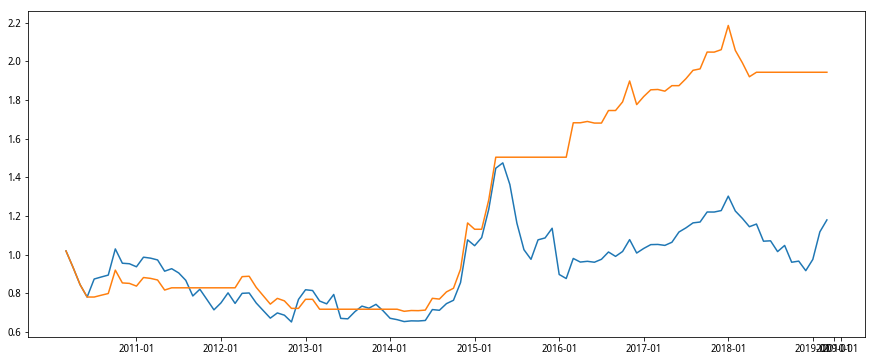

In [6]:
'''
macro.MAC_MANUFACTURING_PMI, 数据本身延迟1个月
delay=3，how=down
1.pmi rolling=2
2.produce_idx rolling=3
3.import_idx rolling=3
4.delivery_time_idx rolling=2
5.finished_produce_idx rolling=1
6.purchase_quantity_idx rolling=1
delay =1
1.delivery_time_idx (14,4)


'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_MANUFACTURING_PMI
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

mac_manufacturing = get_mac_economic_idx(month_list)
mac_manufacturing = mac_manufacturing.sort_index()
pmi = mac_manufacturing['pmi'].sort_index()
pmi = get_rolling_positon(pmi,n=2,delay=3,how='down')
produce_idx = mac_manufacturing['produce_idx'].sort_index()
produce_idx = get_rolling_positon(produce_idx,n=3,delay=3,how='down')
import_idx = mac_manufacturing['import_idx'].sort_index()
import_idx = get_rolling_positon(import_idx,n=3,delay=3,how='down')
delivery_time_idx = mac_manufacturing['delivery_time_idx'].sort_index()
delivery_time_idx = get_rolling_positon(delivery_time_idx,n=2,delay=3,how='down')
finished_produce_idx = mac_manufacturing['finished_produce_idx'].sort_index()
finished_produce_idx = get_rolling_positon(finished_produce_idx,n=1,delay=3,how='down')
purchase_quantity_idx = mac_manufacturing['purchase_quantity_idx'].sort_index()
purchase_quantity_idx = get_rolling_positon(purchase_quantity_idx,n=1,delay=3,how='down')
delivery_time_idx_lsma = mac_manufacturing['delivery_time_idx'].sort_index()
delivery_time_idx_lsma = get_position_from_long_short_monving_average(delivery_time_idx_lsma,long_n=14,short_n=4,delay=1,how='down')
mac_manufacturing_position = pd.concat([pmi,produce_idx,import_idx,delivery_time_idx,finished_produce_idx,purchase_quantity_idx,delivery_time_idx_lsma],axis=1)
mac_manufacturing_position = mac_manufacturing_position.dropna()
mac_manufacturing_position.columns = ['pmi','produce_idx','import_idx','delivery_time_idx','finished_produce_idx','purchase_quantity_idx','delivery_time_idx_lsma']
get_profit_res(delivery_time_idx_lsma,start_date,end_date)

In [7]:
'''
macro.MAC_FIXED_INVESTMENT, 数据本身延迟2个月
delay=2，how=down
1.expand_yoy (10,4)
2.secondary_yoy rolling=2
delay=3
how=up
1.primary_yoy rolling=2 低频高效
delay=3
how=down
1.expand_yoy (8,4)
  continue = 2 低频高效
    
'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_FIXED_INVESTMENT
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

mac_fixed = get_mac_economic_idx(month_list)
mac_fixed = mac_fixed.sort_index()
expand_yoy = mac_fixed['expand_yoy'].sort_index()
expand_yoy = get_position_from_long_short_monving_average(expand_yoy,long_n=10,short_n=4,delay=2,how='down')
secondary_yoy = mac_fixed['secondary_yoy'].sort_index()
secondary_yoy = get_rolling_positon(secondary_yoy,n=2,delay=2,how='down')
primary_yoy = mac_fixed['primary_yoy'].sort_index()
primary_yoy = get_rolling_positon(primary_yoy,n=2,delay=3,how='up')
expand_yoy_lsma = mac_fixed['expand_yoy'].sort_index()
expand_yoy_lsma = get_position_from_long_short_monving_average(expand_yoy_lsma,long_n=8,short_n=4,delay=3,how='down')
expand_yoy_continue = mac_fixed['expand_yoy'].sort_index()
expand_yoy_continue = get_position_from_continus_increase(expand_yoy_continue,n=2,delay=3,how='down')
mac_fixed_position = pd.concat([expand_yoy,secondary_yoy,primary_yoy,expand_yoy_lsma,expand_yoy_continue],axis=1).dropna()
mac_fixed_position.columns = ['expand_yoy','secondary_yoy','primary_yoy','expand_yoy_lsma','expand_yoy_continue']



In [8]:
'''
macro.MAC_INDUSTRY_GROWTH, 数据本身延迟2个月
delay=2，how=up
1.collective_acc rolling=3
2.foreign_yoy (8,2)

delay=2
how=down
1.growth_yoy rolling=1
2.private_yoy rolling=1
3.joint_stock_yoy rolling=1
'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_INDUSTRY_GROWTH
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

mac_industry = get_mac_economic_idx(month_list) #无一月份数据
mac_industry = mac_industry.sort_index()
collective_acc = mac_industry['collective_acc'].sort_index()
collective_acc = get_rolling_positon(collective_acc,n=3,delay=2,how='up')
#foreign_yoy = mac_industry['foreign_yoy'].sort_index()
#foreign_yoy = get_position_from_long_short_monving_average(foreign_yoy,long_n=8,short_n=2,delay=2,how='up')
growth_yoy = mac_industry['growth_yoy'].sort_index()
growth_yoy = get_rolling_positon(growth_yoy,n=1,delay=2,how='down')
private_yoy = mac_industry['private_yoy'].sort_index()
private_yoy = get_rolling_positon(private_yoy,n=1,delay=2,how='down')
joint_stock_yoy = mac_industry['joint_stock_yoy'].sort_index()
joint_stock_yoy = get_rolling_positon(joint_stock_yoy,n=1,delay=2,how='down')
mac_industry_position = pd.concat([collective_acc,growth_yoy,private_yoy,joint_stock_yoy],axis=1).dropna()
mac_industry_position.columns = ['collective_acc','growth_yoy','private_yoy','joint_stock_yoy']


# 做空因子

In [9]:
'''
macro.MAC_MANUFACTURING_PMI 数据本身延迟1个月
delay=1，how=down
1.new_export_orders_idx  coninue=2

delay=3
how=up
1.new_orders_idx (10,2)
2.inventory_idx (10,3)
3.input_idx (10,3)
4.employ_idx (8,4) 低频高效
5.delivery_time_idx （14,2）
6.new_orders_idx continue=2 低频高效
7.order_in_hand_idx rolling=3 

delay=2，how=up
1.inventory_idx （10,4）

'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_MANUFACTURING_PMI
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

mac_manufacturing_sell = get_mac_economic_idx(month_list) #无一月份数据
mac_manufacturing_sell = mac_manufacturing_sell.sort_index()
new_export_orders_idx = mac_manufacturing_sell['new_export_orders_idx'].sort_index()
new_export_orders_idx = get_position_from_continus_increase(new_export_orders_idx,n=2,delay=1,how='down')

'''
macro.MAC_NONMANUFACTURING_PMI
delay=3,how = up
1.new_orders_idx (10,2)
2.inventory_idx (10,3)
3.input_idx (10,3)
4.employ_idx  (8,4)
5.inventory_idx delay=2 (10,4)
'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_NONMANUFACTURING_PMI
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

mac_monmanufacturing_sell = get_mac_economic_idx(month_list)
mac_monmanufacturing_sell = mac_monmanufacturing_sell.sort_index().fillna(method='ffill')
new_orders_idx = mac_monmanufacturing_sell['new_orders_idx'].sort_index()
new_orders_idx = get_position_from_long_short_monving_average(new_orders_idx,long_n=10,short_n=2,delay=3,how='up')
inventory_idx = mac_monmanufacturing_sell['inventory_idx'].sort_index()
inventory_idx = get_position_from_long_short_monving_average(inventory_idx,long_n=10,short_n=3,delay=3,how='up')
input_idx = mac_monmanufacturing_sell['input_idx'].sort_index()
input_idx = get_position_from_long_short_monving_average(input_idx,long_n=10,short_n=3,delay=3,how='up')
employ_idx = mac_monmanufacturing_sell['employ_idx'].sort_index()
employ_idx = get_position_from_long_short_monving_average(employ_idx,long_n=8,short_n=4,delay=3,how='up')
inventory_idx = mac_monmanufacturing_sell['inventory_idx'].sort_index()
inventory_idx = get_position_from_long_short_monving_average(inventory_idx,long_n=10,short_n=4,delay=2,how='up')

'''
macro.MAC_FIXED_INVESTMENT
delay=2,how = up
1.secondary_yoy rolling=2
delay=3
construct_install_yoy rolling=2
'''
def get_mac_economic_idx(month_list):
    mei = macro.MAC_FIXED_INVESTMENT
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month')
    return mac_economic

max_fixed_investment = get_mac_economic_idx(month_list)
max_fixed_investment = max_fixed_investment.sort_index().fillna(method='ffill')
secondary_yoy = max_fixed_investment['secondary_yoy'].sort_index()
secondary_yoy = get_rolling_positon(secondary_yoy,2,delay=2,how='up')
construct_install_yoy = max_fixed_investment['construct_install_yoy'].sort_index()
construct_install_yoy = get_rolling_positon(construct_install_yoy,2,delay=2,how='up')

all_position_for_sell = pd.concat([new_export_orders_idx,new_orders_idx,inventory_idx,input_idx,employ_idx,inventory_idx,secondary_yoy,construct_install_yoy],axis=1)
all_position_for_sell.columns = ['new_export_orders_idx','new_orders_idx','inventory_idx','input_idx','employ_idx','inventory_idx','secondary_yoy','construct_install_yoy']
all_position_for_sell = all_position_for_sell.fillna(method='ffill').dropna()


In [10]:
all_position = pd.concat([mac_manufacturing_position,mac_fixed_position,mac_industry_position],axis=1).dropna()
profit = get_profit_monthly(start_date=start_date,end_date=end_date)
profit_continue = get_profit_monthly(start_date=start_date,end_date=end_date,label=False)
sel_index = all_position.index
profit = profit.ix[sel_index]
profit_continue = profit_continue.ix[sel_index]

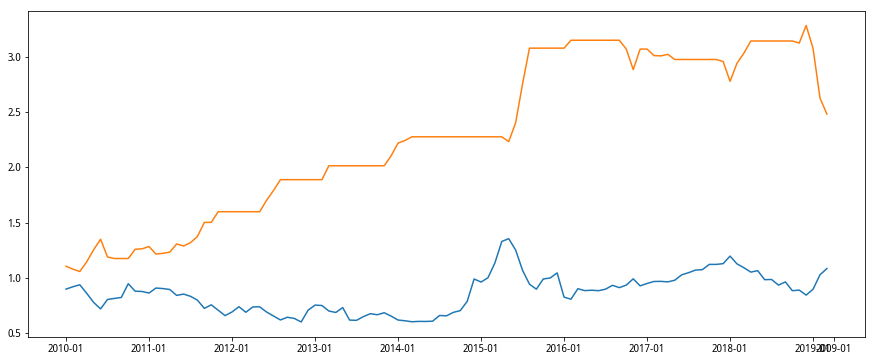

In [11]:
#做多
len_col = len(all_position.columns)
sum_position = all_position.sum(axis=1)

thre = 0.45
predict_position = sum_position/len_col
#print(predict_position)
predict_position[predict_position >= thre] = 1
predict_position[predict_position < thre] = 0

#做空
predict_position_for_sell = all_position_for_sell.sum(axis=1) / len(all_position_for_sell.columns)

thre_sell = 0.5
predict_position_for_sell[predict_position_for_sell >= thre_sell] = 1
predict_position_for_sell[predict_position_for_sell < thre_sell] = 0
predict_position_for_sell = predict_position_for_sell.to_frame()
predict_position_for_sell.columns = ['position']

get_profit_res_for_sell(predict_position_for_sell,start_date,end_date)
predict_position_for_sell[predict_position_for_sell==1] = -1


In [12]:
combine_position = pd.concat([predict_position,predict_position_for_sell],axis=1).dropna()
combine_position.columns = ['buy','sell']
combine_position['combine'] = combine_position['buy'] + combine_position['sell']
combine_position = combine_position['combine']

stratage profit:  4.555235896697446
stratage / base profit:  3.5576211734745407
correct ratio:  0.6935483870967742
max drawdown:  0.2339005442953601


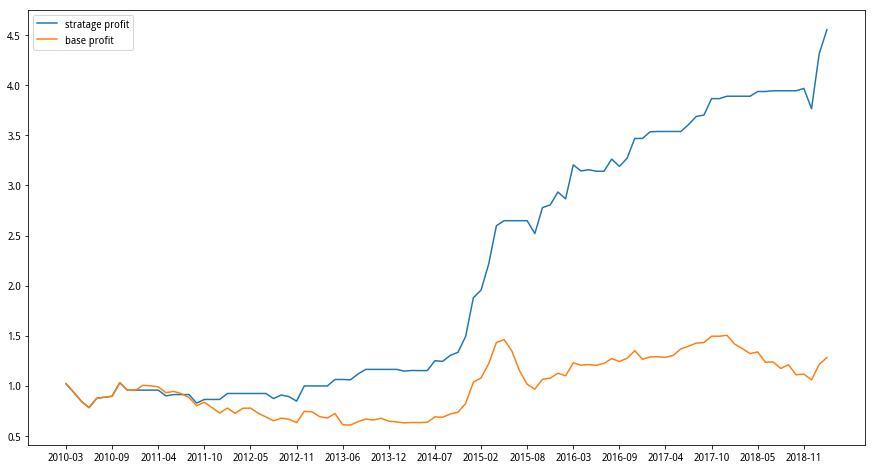

In [13]:
#做多
def get_cumprod_profit(profit,profit_continue,predict):
    profit_continue['profit'] = profit
    profit_continue['predict'] = predict
    profit_continue['profit_multiply_predict'] = (profit_continue['pct'] * profit_continue['predict'])
    profit_continue['profit_cumprod'] = (profit_continue['profit_multiply_predict'] + 1).cumprod()
    profit_continue['original_profit'] = (profit_continue['pct'] + 1).cumprod()
    profit_continue['correct'] = profit_continue['predict'] * profit_continue['profit']
    profit_continue['correct'][profit_continue['correct']==-1] = 0
    correct_ratio = profit_continue['correct'].sum() / profit_continue['predict'].sum()
    max_drawdown = find_max_drawdown(profit_continue['profit_cumprod'])
    base_profit = (profit_continue['pct'] +1 ).cumprod().iloc[-1]
    celve_profit =  profit_continue['profit_cumprod'].iloc[-1]
    fig = plt.figure(figsize=(15,8))
    plt.plot(profit_continue['profit_cumprod'],label='stratage profit')
    plt.plot(profit_continue['original_profit'],label='base profit')
    plt.legend()
    ind = profit_continue.index
    plt.xticks(ind[::6])
    print('stratage profit: ',celve_profit)
    print('stratage / base profit: ',celve_profit/base_profit)
    print('correct ratio: ',correct_ratio)
    print('max drawdown: ',max_drawdown)
   # print(profit_continue)
    #print(profit_continue)
get_cumprod_profit(profit,profit_continue,predict_position)

stratage profit:  12.191638501783478
stratage / base profit:  9.521621329147411
correct ratio:  0.8166666666666667
max drawdown:  0.06691785391891358


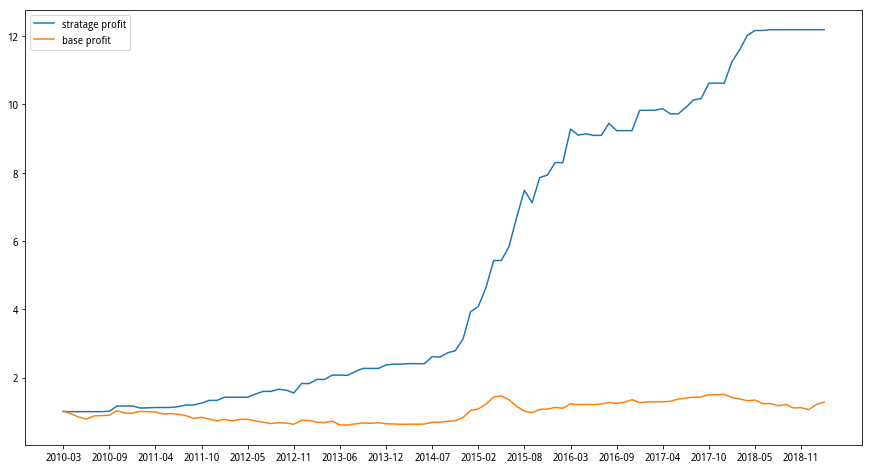

In [14]:
#多空结合
def get_cumprod_profit_for_buy_and_sell(profit,profit_continue,predict):
    profit_continue['profit'] = profit
    profit_continue['predict'] = predict
    profit_continue['profit_multiply_predict'] = (profit_continue['pct'] * profit_continue['predict'])
    profit_continue['profit_cumprod'] = (profit_continue['profit_multiply_predict'] + 1).cumprod()
    profit_continue['original_profit'] = (profit_continue['pct'] + 1).cumprod()
    profit_continue['correct'] = profit_continue['predict'] * profit_continue['profit']
    profit_continue['correct'][profit_continue['correct']==-1] = 0
    profit_continue['predict_num'] = profit_continue['predict']
    profit_continue['predict_num'][profit_continue['predict_num']==-1] = 1
    correct_ratio = profit_continue['correct'].sum() / profit_continue['predict_num'].sum()
    max_drawdown = find_max_drawdown(profit_continue['profit_cumprod'])
    base_profit = (profit_continue['pct'] +1 ).cumprod().iloc[-1]
    celve_profit =  profit_continue['profit_cumprod'].iloc[-1]
    fig = plt.figure(figsize=(15,8))
    plt.plot(profit_continue['profit_cumprod'],label='stratage profit')
    plt.plot(profit_continue['original_profit'],label='base profit')
    plt.legend()
    ind = profit_continue.index
    plt.xticks(ind[::6])
    print('stratage profit: ',celve_profit)
    print('stratage / base profit: ',celve_profit/base_profit)
    print('correct ratio: ',correct_ratio)
    print('max drawdown: ',max_drawdown)
    #print(profit_continue)
    #print(profit_continue)
get_cumprod_profit_for_buy_and_sell(profit,profit_continue,combine_position)